In [32]:
# 전처리 패키지
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# 모델링 패키지
from sklearn.ensemble import RandomForestClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# 모델 평가 및 검증 패키지
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score


# 기타 패키지
import random
import os
from datetime import datetime
import time
import math

In [33]:
train = pd.read_csv('C:/lg_capstone/find_abnormal/data/train_begin.csv')
test = pd.read_csv('C:/lg_capstone/find_abnormal/data/test_begin.csv')
# submission = pd.read_csv('./sample_submission.csv')

In [34]:
all_data = pd.concat([train, test], sort=False)
all_data.reset_index(drop=True, inplace=True) # all_data의 인덱스를 0부터 순차적으로 변경(concat하면 index가 중복될 수 있기 때문에 reset_index() 사용)

## 인코딩(범주형 -> 수치형)

In [35]:
# 1. 범주형 컬럼들을 Label Encoding하기
le = LabelEncoder()

# 1) Equipment_Suffix 컬럼을 Label Encoding하기
suffixes = ['Dam', 'Fill1', 'Fill2']
for suffix in suffixes:
    for column in [f'Equipment_{suffix}']:
        all_data[column] = all_data[column].astype(str)
        le.fit(all_data[column])
        all_data[column] = le.transform(all_data[column])


# 2) Model.Suffix_Dam, Workorder_Dam 컬럼을 Label Encoding하기
li = ['Model.Suffix_Dam','Workorder_Dam']
for column in li:
    all_data[column] = all_data[column].astype(str)
    le.fit(all_data[column])
    all_data[column] = le.transform(all_data[column])


# 3) Chamber Temp. Judge Value_AutoClave(탈포 판단값) 컬럼을 Label Encoding하기
all_data['Chamber Temp. Judge Value_AutoClave'] = all_data['Chamber Temp. Judge Value_AutoClave'].astype(str)
le.fit(all_data['Chamber Temp. Judge Value_AutoClave'])
all_data['Chamber Temp. Judge Value_AutoClave'] = le.transform(all_data['Chamber Temp. Judge Value_AutoClave'])


# 4) GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave 컬럼을 Label Encoding하기
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].astype(str)
le.fit(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = le.transform(all_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'])
all_data = all_data.drop(columns='GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave')

## Equipment(Line #1, #2) 또는 PalletID 또는 Production Qty 중 하나라도 다른 데이터 확인하기

<span style="font-size: 25px">all_data -> same_data & diff_data</span>
<br>
<br>
- same_data: Equipment(Line #1, #2)와 PalletID와 Production Qty가 모두 같은 데이터<br><br>
- diff_data: Equipment(Line #1, #2) 또는 PalletID 또는 Production Qty 중 하나라도 다른 데이터

In [36]:
# Equipment_Dam, Equipment_Fill1, Equipment_Fill2의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same 저장
index_of_diff = []
index_of_same = []

dam_values = all_data['Equipment_Dam'].values
fill1_values = all_data['Equipment_Fill1'].values
fill2_values = all_data['Equipment_Fill2'].values

index_of_diff = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


# PalletID Collect Result_Dam, PalletID Collect Result_Fill1, PalletID Collect Result_Dam 의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same append
index_of_diff2 = []
index_of_same2 = []

dam_values = all_data['PalletID Collect Result_Dam'].values
fill1_values = all_data['PalletID Collect Result_Fill1'].values
fill2_values = all_data['PalletID Collect Result_Fill2'].values

index_of_diff2 = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same2 = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


# Production Qty Collect Result_Dam, Production Qty Collect Result_Fill1, Production Qty Collect Result_Fill2의 값을 비교하여 다르면 해당 데이터의 인덱스를 index_of_diff, 같으면 index_of_same append
index_of_diff3 = []
index_of_same3 = []

dam_values = all_data['Production Qty Collect Result_Dam'].values
fill1_values = all_data['Production Qty Collect Result_Fill1'].values
fill2_values = all_data['Production Qty Collect Result_Fill2'].values

index_of_diff3 = np.where((dam_values != fill1_values) | (dam_values != fill2_values))[0].tolist()
index_of_same3 = np.where((dam_values == fill1_values) & (dam_values == fill2_values))[0].tolist()


In [37]:
# 3개의 필터링 결과 합치기
index_of_diff_total = list(set(index_of_diff + index_of_diff2 + index_of_diff3))

# index_of_diff_total의 중복값 제거
index_of_diff_total = list(set(index_of_diff_total))


# index_of_diff_total에 해당하는 데이터를 diff_data에 저장하고, 해당하지 않는 나머지 데이터를 same_data에 저장
diff_data = all_data.loc[index_of_diff_total]
same_data = all_data.drop(index=index_of_diff_total)

In [38]:
# diff_data의 'target' 컬럼이 nan인 행만 추출하여 diff_test에 저장
diff_test = diff_data[diff_data['target'].isnull()]

# diff_test의 'target' 컬럼의 값을 모두 'AbNormal'로 변경
diff_test['target'] = 'AbNormal'

# diff_test의 'Set ID'와 'target' 컬럼만 선택하여 submission_diff에 저장
submission_diff = diff_test[['Set ID', 'target']]

C:\Users\user\AppData\Local\Temp\ipykernel_9600\450733750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_test['target'] = 'AbNormal'


## same_data 전처리

In [39]:
all_data = same_data

### 불필요한 컬럼 제거하기

In [40]:
all_data = all_data.drop(columns=['Equipment_Fill1','Equipment_Fill2',
                                    'PalletID Collect Result_Dam','PalletID Collect Result_Fill1','PalletID Collect Result_Fill2',
                                    # 'Production Qty Collect Result_Fill1','Production Qty Collect Result_Fill2'
                                  ])

In [41]:
unnecessary_columns =['Model.Suffix_AutoClave','Model.Suffix_Fill1','Model.Suffix_Fill2',
    'Workorder_AutoClave','Workorder_Fill1','Workorder_Fill2',
    'Receip No Collect Result_Fill1','Receip No Collect Result_Fill2',]
all_data = all_data.drop(unnecessary_columns , axis=1)

# 열 목록 정의
cols_to_average = ['Stage1 Circle1 Distance Speed Collect Result_Dam',
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam',
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam',
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam',
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 평균 값 계산 및 새로운 열 추가
# all_data['Average Stage1 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:4]].mean(axis=1)
# all_data['Average Stage1 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[4:8]].mean(axis=1)
# all_data['Average Stage2 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:12]].mean(axis=1)
# all_data['Average Stage2 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[12:16]].mean(axis=1)
# all_data['Average Stage3 Circle Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:20]].mean(axis=1)
# all_data['Average Stage3 Line Distance Speed Collect Result_Dam'] = all_data[cols_to_average[20:24]].mean(axis=1)

all_data['Average Stage1 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[:8]].mean(axis=1)
all_data['Average Stage2 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[8:16]].mean(axis=1)
all_data['Average Stage3 CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average[16:]].mean(axis=1)

# all_data['Average CL Distance Speed Collect Result_Dam'] = all_data[cols_to_average].mean(axis=1)

# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)


cols_to_average = [
                'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',

                  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
                  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',        
]

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[:3]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[3:6]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Dam'] = all_data[cols_to_average[6:9]].mean(axis=1)

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[9:12]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[12:15]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill1'] = all_data[cols_to_average[15:18]].mean(axis=1)

all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[18:21]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Y AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[21:24]].mean(axis=1)
all_data['HEAD NORMAL COORDINATE Z AXIS(Stage) Collect Result_Fill2'] = all_data[cols_to_average[24:]].mean(axis=1)
# all_data['HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill2'] = abs(all_data[cols_to_average[18]]-all_data[cols_to_average[19]])+abs(all_data[cols_to_average[19]]-all_data[cols_to_average[20]])


# 기존 열 삭제
all_data = all_data.drop(columns=cols_to_average)


all_data['CURE POSITION X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])
all_data['CURE POSITION Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])
all_data['CURE POSITION Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])

# all_data['CURE TIME X Collect Result_Dam'] = abs(all_data['CURE START POSITION X Collect Result_Dam']-all_data['CURE END POSITION X Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Z Collect Result_Dam'] = abs(all_data['CURE START POSITION Z Collect Result_Dam']-all_data['CURE END POSITION Z Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']
# all_data['CURE TIME Θ Collect Result_Dam'] = abs(all_data['CURE START POSITION Θ Collect Result_Dam']-all_data['CURE END POSITION Θ Collect Result_Dam'])/all_data['CURE SPEED Collect Result_Dam']

all_data['CURE POSITION X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])
all_data['CURE POSITION Z Collect Result_Fill2'] = abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2'])

# all_data['CURE TIME X Collect Result_Fill2'] = abs(all_data['CURE START POSITION X Collect Result_Fill2']-all_data['CURE END POSITION X Collect Result_Fill2'])/all_data['CURE SPEED Collect Result_Fill2']
# all_data['CURE TIME Z Collect Result_Fill2'] = (abs(all_data['CURE START POSITION Z Collect Result_Fill2']-all_data['CURE STANDBY POSITION Z Collect Result_Fill2'])+abs(all_data['CURE STANDBY POSITION Z Collect Result_Fill2']-all_data['CURE END POSITION Z Collect Result_Fill2']))/all_data['CURE SPEED Collect Result_Fill2']


# 기존 열 삭제
all_data = all_data.drop(columns=[
                                  'CURE START POSITION X Collect Result_Dam','CURE START POSITION Θ Collect Result_Dam',
                                  'CURE END POSITION X Collect Result_Dam','CURE END POSITION Z Collect Result_Dam','CURE END POSITION Θ Collect Result_Dam','CURE SPEED Collect Result_Dam',
                                  'CURE STANDBY POSITION Z Collect Result_Fill2',
                                  'CURE START POSITION X Collect Result_Fill2','CURE START POSITION Z Collect Result_Fill2',
                                  'CURE END POSITION X Collect Result_Fill2','CURE END POSITION Z Collect Result_Fill2','CURE SPEED Collect Result_Fill2'
                                  ])






all_data['Machine Tact time'] = all_data['Machine Tact time Collect Result_Dam'] + all_data['Machine Tact time Collect Result_Fill1'] + all_data['Machine Tact time Collect Result_Fill2']

all_data = all_data.drop(columns=['Machine Tact time Collect Result_Dam','Machine Tact time Collect Result_Fill1','Machine Tact time Collect Result_Fill2'])

In [42]:
# 추가적인 상호작용 피처 생성
# 속도와 시간의 조합으로 새로운 피처 생성 (예: 거리 계산)
all_data['Speed_Time_Interaction_Stage1 Result_Dam'] = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
)

all_data['Speed_Time_Interaction_Stage2 Result_Dam'] = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
)

all_data['Speed_Time_Interaction_Stage3 Result_Dam'] = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Dam'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']
)

all_data['Total Speed_Time Result_Dam'] = all_data['Speed_Time_Interaction_Stage1 Result_Dam']+all_data['Speed_Time_Interaction_Stage2 Result_Dam']+all_data['Speed_Time_Interaction_Stage3 Result_Dam']

# 도메인 지식을 활용한 피처 생성: 예를 들어 레진 분사 과정에서 발생할 수 있는 레진 양과 관련된 계산
all_data['Total_Dispense_Volume Result_Dam'] = (
    all_data['Dispense Volume(Stage1) Collect Result_Dam'] +
    all_data['Dispense Volume(Stage2) Collect Result_Dam'] +
    all_data['Dispense Volume(Stage3) Collect Result_Dam']
)

all_data = all_data.drop(columns=[
                                    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
                                    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
                                    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
                                    'Dispense Volume(Stage1) Collect Result_Dam',
                                    'Dispense Volume(Stage2) Collect Result_Dam',
                                    'Dispense Volume(Stage3) Collect Result_Dam'         
                                              ])

In [43]:
a = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
)

b = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
)

c = (
    all_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * 
    all_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']
)

all_data['Total Speed_Time Result_Fill1'] = a+b+c

# 도메인 지식을 활용한 피처 생성: 예를 들어 레진 분사 과정에서 발생할 수 있는 레진 양과 관련된 계산
all_data['Total_Dispense_Volume Result_Fill1'] = (
    all_data['Dispense Volume(Stage1) Collect Result_Fill1'] +
    all_data['Dispense Volume(Stage2) Collect Result_Fill1']+
    all_data['Dispense Volume(Stage3) Collect Result_Fill1']
)

all_data = all_data.drop(columns=[
                                    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
                                    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
                                    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
                                    'Dispense Volume(Stage1) Collect Result_Fill1',
                                    'Dispense Volume(Stage2) Collect Result_Fill1',
                                    'Dispense Volume(Stage3) Collect Result_Fill1'        
                                    ])

In [44]:

all_data['1st Pressure Time Result_AutoClave'] = all_data['1st Pressure Collect Result_AutoClave'] * all_data['1st Pressure 1st Pressure Unit Time_AutoClave']
all_data['2nd Pressure Time Result_AutoClave'] = all_data['2nd Pressure Collect Result_AutoClave'] * all_data['2nd Pressure Unit Time_AutoClave']
all_data['3rd Pressure Time Result_AutoClave'] = all_data['3rd Pressure Collect Result_AutoClave'] * all_data['3rd Pressure Unit Time_AutoClave']

a = all_data['1st Pressure Collect Result_AutoClave'] * all_data['1st Pressure 1st Pressure Unit Time_AutoClave']
b = all_data['2nd Pressure Collect Result_AutoClave'] * all_data['2nd Pressure Unit Time_AutoClave']
c = all_data['3rd Pressure Collect Result_AutoClave'] * all_data['3rd Pressure Unit Time_AutoClave']

all_data['Pressure Amount'] = a+b+c
all_data.replace([np.inf, -np.inf], 0, inplace=True)

# 삭제할 칼럼 목록
# columns_to_drop = [
#     'THICKNESS 1 Collect Result_Dam',
#     'THICKNESS 2 Collect Result_Dam',
#     'THICKNESS 3 Collect Result_Dam',
#     '1st Pressure Collect Result_AutoClave',
#     '1st Pressure 1st Pressure Unit Time_AutoClave',
#     '2nd Pressure Collect Result_AutoClave',
#     '2nd Pressure Unit Time_AutoClave',
#     '3rd Pressure Collect Result_AutoClave',
#     '3rd Pressure Unit Time_AutoClave',
#     'Chamber Temp. Collect Result_AutoClave',
#     'Chamber Temp. Unit Time_AutoClave',
# ]

# 칼럼 삭제
# all_data = all_data.drop(columns=columns_to_drop)

### 비대칭성 높은 칼럼 정규화

In [45]:
a=[]
for c in all_data.columns:
    if all_data[c].nunique()==1:
        a.append(c)
all_data.drop(columns=a, inplace=True)


# 모든 칼럼의 왜도(Skewness) 계산
train_X = all_data[~pd.isnull(all_data['target'])]
train_x = train_X.drop(columns=['target','Set ID'])
skewness = train_x.skew().sort_values(ascending=False)

# 비대칭성이 높은 칼럼(왜도의 절대값이 1보다 큰 칼럼) 추출
high_skew_cols_list = skewness[abs(skewness) > 1].index.tolist()

# 로그 변환을 위한 작은 상수 추가
epsilon = 1e-6

# 로그 변환을 적용할 칼럼 리스트에서 'PalletID'와 'Production Qty'를 제외
high_skew_cols_list = [col for col in high_skew_cols_list if col not in ['PalletID', 'Production Qty']]

# 로그 변환 적용
for col in high_skew_cols_list:
    if any(all_data[col] <= 0):  # 0 또는 음수 값이 있는 경우 상수 추가
        all_data[col] = np.log1p(all_data[col] + epsilon)
    else:
        all_data[col] = np.log1p(all_data[col])

### 표준화

In [46]:
scaler = StandardScaler()
all_data[high_skew_cols_list] = scaler.fit_transform(all_data[high_skew_cols_list])


### 결측치 처리

In [47]:
# NaN 값을 0으로 대체
# all_data['AVERAGE DISCHARGED SPEED Fill1'] = all_data['AVERAGE DISCHARGED SPEED Fill1'].fillna(0)
# all_data['Average SPEED PER TIME Fill1'] = all_data['Average SPEED PER TIME Fill1'].fillna(0)
all_data.fillna({col: 0 for col in all_data.columns if col not in ['target', 'Set ID']}, inplace=True)

train_X = all_data[~pd.isnull(all_data['target'])]
train_x = train_X.drop(columns='Set ID')

### 상관계수 절대값 상위 40개 추출

Top 20 Correlations with Target:
target                                                       1.000000
Speed_Time_Interaction_Stage3 Result_Dam                     0.066992
Speed_Time_Interaction_Stage1 Result_Dam                     0.066780
Total Speed_Time Result_Dam                                  0.066550
Head Zero Position Y Collect Result_Dam                      0.065833
Average Stage2 CL Distance Speed Collect Result_Dam          0.063550
Workorder_Dam                                                0.059662
Speed_Time_Interaction_Stage2 Result_Dam                     0.058925
Head Purge Position Z Collect Result_Fill1                   0.058668
Average Stage3 CL Distance Speed Collect Result_Dam          0.057233
Average Stage1 CL Distance Speed Collect Result_Dam          0.057227
Machine Tact time                                            0.055966
Total Speed_Time Result_Fill1                                0.054609
HEAD NORMAL COORDINATE X AXIS(Stage) Collect Result_Fill1

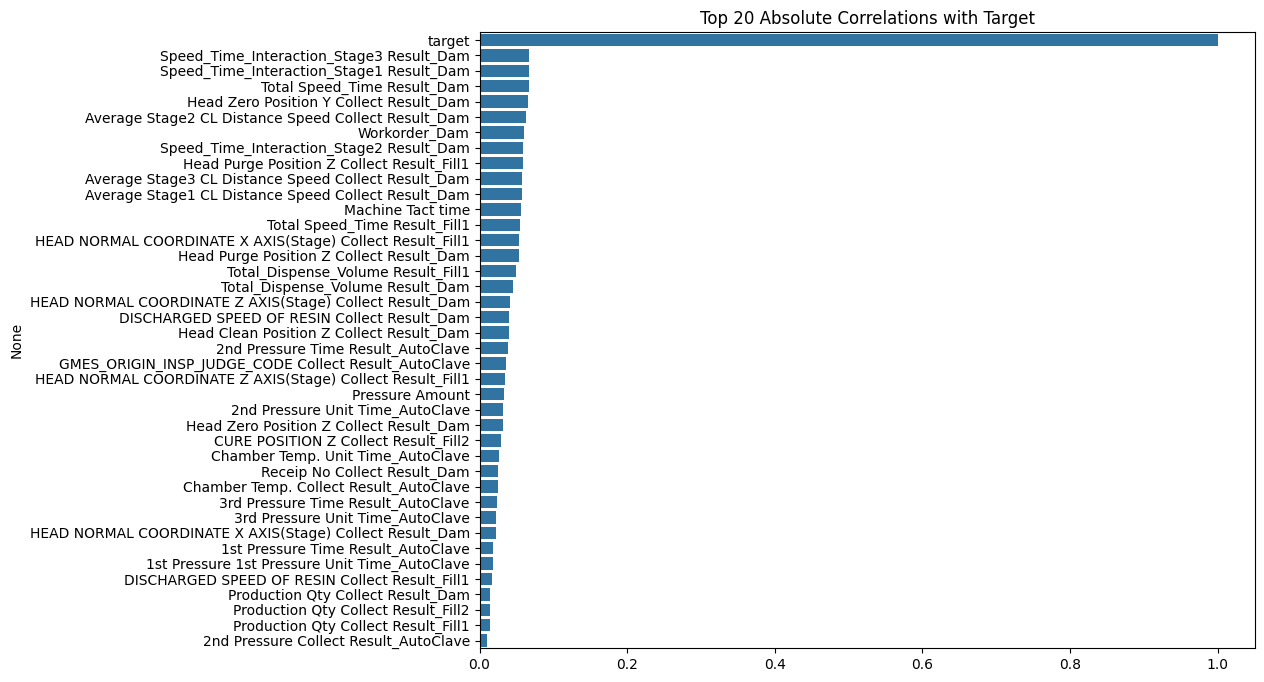

In [48]:
# LabelEncoder 초기화
le = LabelEncoder()

# target과 feature 분리
X = train_x.drop(columns=['target'])  # target을 제외한 피처들
y = train_X['target']  # target 변수

# target을 문자열로 변환 후 Label Encoding
y = y.astype(str)
y = le.fit_transform(y)

# 데이터프레임에 target 추가 (상관계수를 계산하기 위해)
df = X.copy()
df['target'] = y

# 상관계수 계산
correlation_matrix = df.corr()

# target과의 상관계수 추출 및 절대값 기준 상위 20개 선택
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False).head(40)

top_10_corr = target_corr.head(20)
print("Top 20 Correlations with Target:")
print(top_10_corr)

# 상위 20개의 피처 목록 추출 (target 포함)
top_features = target_corr.index.tolist()
top_features.append('Equipment_Dam')
# all_data에서 상위 20개의 피처만 선택
all_data_top20 = all_data[top_features]

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Top 20 Absolute Correlations with Target')
plt.show()


In [49]:
train_X = all_data_top20[~pd.isnull(all_data['target'])]
# train_x = train_X.drop(columns='Set ID')

### PCA 적용

In [50]:
# 타겟 변수를 제외한 피처들만 사용
features = train_X.drop(columns=['target'])

# 데이터 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA 적용
pca = PCA(n_components=0.95)  # 설명 분산의 95%를 유지하도록 설정
pca_features = pca.fit_transform(scaled_features)

# PCA 적용 후 데이터셋의 형태 확인
pca_features_shape = pca_features.shape

# 설명된 분산 비율
explained_variance = pca.explained_variance_ratio_

pca_features_shape, explained_variance

((40413, 15),
 array([0.39391682, 0.11954676, 0.0818205 , 0.06043446, 0.0524523 ,
        0.04433725, 0.03743312, 0.02808113, 0.0251551 , 0.02462576,
        0.022269  , 0.02127489, 0.01951217, 0.01230955, 0.01049671]))

In [51]:
test1 = all_data_top20[pd.isnull(all_data_top20['target'])]
test2 = all_data[pd.isnull(all_data['target'])]
# test_x = test.drop(columns=['Set ID','target'])
test_x = test1.drop(columns=['target'])

## 모델1 - 기본 모델 훈련

In [52]:
from sklearn.ensemble import RandomForestClassifier

# 타겟 변수
target = train_X['target']

target = target.astype(str)
target = le.fit_transform(target)

# 데이터 분리 (학습용 80%, 검증용 20%)
X_train, X_val, y_train, y_val = train_test_split(pca_features, target, test_size=0.2, random_state=42)

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [53]:


# # 1. 기본 랜덤 포레스트 모델 학습
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train_smote, y_train_smote)

# # 예측
# y_pred = model.predict(X_val)

# # 성능 평가
# accuracy = accuracy_score(y_val, y_pred)
# classification_rep = classification_report(y_val, y_pred, digits=4)


# print("기본 모델 성능")
# print("Accuracy:", accuracy)
# print("Classification Report:\n", classification_rep)

## 모델2 - AbNormal에 가중치 적용해 새로운 모델 훈련

In [54]:
# # 1. SMOTE를 적용하여 학습한 랜덤 포레스트 모델
# model_weighted_smote = RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 10})
# model_weighted_smote.fit(X_train_smote, y_train_smote)

# # 2. 검증 데이터셋에서 예측 수행
# y_pred_weighted_val = model_weighted_smote.predict(X_val)

# # 3. 성능 평가
# accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
# classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

# print("SMOTE 적용 모델 성능")
# print("Accuracy:", accuracy_weighted_val)
# print("Classification Report:\n", classification_rep_weighted_val)

# # 4. 테스트 데이터에 PCA 및 스케일러 적용
# scaled_features_test = scaler.transform(test_x)
# pca_features_test = pca.transform(scaled_features_test)

# # 5. 테스트 데이터에서 예측 수행
# y_pred_test = model_weighted_smote.predict(pca_features_test)

In [55]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification

## 앙상블: RF, XGB, LGBM

2085

In [72]:
# 모델 생성
rf_model = RandomForestClassifier(n_estimators = 118, max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, class_weight={0: 1, 1: 20}, random_state=42)
xgb_model = XGBClassifier(n_estimators = 286, max_depth = 10, learning_rate = 0.21366513084005267, subsample = 0.6122668648564789, colsample_bytree = 0.7768644502170545, gamma = 0.2855489821421704, min_child_weight = 1, random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# 소프트 보팅 앙상블 모델 생성
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
], voting='soft')

# 모델 학습
voting_model.fit(X_train_smote, y_train_smote)

# 검증 데이터에 대한 예측
y_val_pred = voting_model.predict(X_val)

# 분류 리포트 출력
print(classification_report(y_val, y_val_pred))

[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.16      0.10      0.12       441
           1       0.95      0.97      0.96      7642

    accuracy                           0.92      8083
   macro avg       0.56      0.53      0.54      8083
weighted avg       0.91      0.92      0.91      8083



1993

In [78]:
# 모델 생성
rf_model = RandomForestClassifier(n_estimators = 218, max_depth = 50, min_samples_split = 2, min_samples_leaf = 1, class_weight={0: 1, 1: 20}, random_state=42)
xgb_model = XGBClassifier(n_estimators = 286, max_depth = 10, learning_rate = 0.21366513084005267, subsample = 0.6122668648564789, colsample_bytree = 0.7768644502170545, gamma = 0.2855489821421704, min_child_weight = 1, random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# 소프트 보팅 앙상블 모델 생성
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
], voting='soft')

# 모델 학습
voting_model.fit(X_train_smote, y_train_smote)

# 검증 데이터에 대한 예측
y_val_pred = voting_model.predict(X_val)

# 분류 리포트 출력
print(classification_report(y_val, y_val_pred))

[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.10      0.18      0.13       441
           1       0.95      0.91      0.93      7642

    accuracy                           0.87      8083
   macro avg       0.53      0.54      0.53      8083
weighted avg       0.90      0.87      0.89      8083



Trial 3: 미제출

In [ ]:
# 모델 생성
rf_model = RandomForestClassifier(n_estimators = 98, max_depth = 29, min_samples_split = 9, min_samples_leaf = 2, class_weight={0: 1, 1: 20}, random_state=42)
xgb_model = XGBClassifier(n_estimators = 286, max_depth = 10, learning_rate = 0.21366513084005267, subsample = 0.6122668648564789, colsample_bytree = 0.7768644502170545, gamma = 0.2855489821421704, min_child_weight = 1, random_state=42)
lgbm_model = LGBMClassifier(n_estimators = 261, max_depth = 17, learning_rate = 0.1463413340517554, subsample = 0.7528924911295741, colsample_bytree = 0.6759922637460025, num_leaves = 255, min_child_samples = 11, scale_pos_weight = 10, random_state=42)

# 소프트 보팅 앙상블 모델 생성
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
], voting='soft')

# 모델 학습
voting_model.fit(X_train_smote, y_train_smote)

# 검증 데이터에 대한 예측
y_val_pred = voting_model.predict(X_val)

# 분류 리포트 출력
print(classification_report(y_val, y_val_pred))

RF 하이퍼 파라미터 튜닝

In [86]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

def objective(trial):
    # 하이퍼파라미터 설정
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 35)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)

    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight={0: 1, 1: 15}
    )

    # 모델 학습
    model.fit(X_train_smote, y_train_smote)

    # 검증 데이터에 대한 예측 및 정확도 계산
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, pos_label=0)  # pos_label=0은 양성 클래스

    return f1

In [87]:
# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

# 최적 모델로 재학습 및 검증
best_params = study.best_params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42,
    class_weight={0: 1, 1: 15}
)

[I 2024-08-29 06:11:48,314] A new study created in memory with name: no-name-c5bba7d1-713f-4850-903d-92a2249a1bd8
[I 2024-08-29 06:12:02,019] Trial 0 finished with value: 0.056155507559395246 and parameters: {'n_estimators': 110, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.056155507559395246.
[I 2024-08-29 06:12:30,397] Trial 1 finished with value: 0.13318284424379231 and parameters: {'n_estimators': 85, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.13318284424379231.
[I 2024-08-29 06:13:58,491] Trial 2 finished with value: 0.12379642365887207 and parameters: {'n_estimators': 295, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.13318284424379231.
[I 2024-08-29 06:15:03,683] Trial 3 finished with value: 0.1070811744386874 and parameters: {'n_estimators': 228, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 1 wit

Best hyperparameters:  {'n_estimators': 151, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 1}


In [ ]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

def objective(trial):
    # 하이퍼파라미터 설정
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 35)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)

    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight={0: 1, 1: 10}
    )

    # 모델 학습
    model.fit(X_train_smote, y_train_smote)

    # 검증 데이터에 대한 예측 및 정확도 계산
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, pos_label=0)  # pos_label=0은 양성 클래스

    return f1

XGBoost 하이퍼 파라미터 튜닝

In [68]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification


def objective(trial):
    # 하이퍼파라미터 설정
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 5, 25),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # XGBClassifier 모델 생성
    model = XGBClassifier(**params, random_state=42)

    # 모델 학습
    model.fit(X_train_smote, y_train_smote)

    # 검증 데이터에 대한 예측 및 정확도 계산
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, pos_label=0)  # pos_label=1은 양성 클래스
    
    return f1



In [69]:
# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

# 최적 모델로 재학습 및 검증
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42)

best_model.fit(X_train_smote, y_train_smote)
y_val_pred = best_model.predict(X_val)

# 분류 리포트 출력
print(classification_report(y_val, y_val_pred))

[I 2024-08-29 05:46:38,026] A new study created in memory with name: no-name-f3c8ac66-efac-4a8e-a3e2-06d86a24b003
C:\Users\user\AppData\Local\Temp\ipykernel_9600\2512104123.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
[I 2024-08-29 05:46:38,739] Trial 0 finished with value: 0.09090909090909091 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.2715249470315938, 'subsample': 0.9197915771105079, 'colsample_bytree': 0.7848300868462932, 'gamma': 2.4162098187017733, 'min_child_weight': 2, 'scale_pos_weight': 25, 'reg_alpha': 5.174869651259838, 'reg_lambda': 4.203550798889632}. Best is trial 0 with value: 0.09090909090909091.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\2512104123.py:15: FutureWarning: suggest_loguniform has been d

Best hyperparameters:  {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.2222769197887398, 'subsample': 0.5524362181641634, 'colsample_bytree': 0.668171807092532, 'gamma': 0.8528635227039771, 'min_child_weight': 9, 'scale_pos_weight': 5, 'reg_alpha': 9.677960661115003, 'reg_lambda': 1.105664914847701}
              precision    recall  f1-score   support

           0       0.17      0.11      0.13       441
           1       0.95      0.97      0.96      7642

    accuracy                           0.92      8083
   macro avg       0.56      0.54      0.55      8083
weighted avg       0.91      0.92      0.91      8083



LightGBM 하이퍼 파라미터 튜닝

In [70]:
import lightgbm as lgb

def objective(trial):
    # 하이퍼파라미터 설정
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', -1, 30),  # -1은 무제한
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 5, 25),
    }

    # LightGBM 모델 생성
    model = lgb.LGBMClassifier(**params, random_state=42)

    # 모델 학습
    model.fit(X_train_smote, y_train_smote)

       # 검증 데이터에 대한 예측 및 정확도 계산
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, pos_label=0)  # pos_label=0은 양성 클래스

    return f1

In [71]:
# Optuna 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

# 최적 모델로 재학습 및 검증
best_params = study.best_params
best_model = lgb.LGBMClassifier(**best_params, random_state=42)

best_model.fit(X_train_smote, y_train_smote)
y_val_pred = best_model.predict(X_val)

# 분류 리포트 출력
print(classification_report(y_val, y_val_pred))

[I 2024-08-29 05:47:34,678] A new study created in memory with name: no-name-8e94239b-6377-401e-a1b3-d85f1124003a
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:35,131] Trial 0 finished with value: 0.06823027718550106 and parameters: {'n_estimators': 160, 'max_depth': 25, 'learning_rate': 0.028908597406446853, 'subsample': 0.7973197150669168, 'colsample_bytree': 0.6612956014553808, 'num_leaves': 90, 'min_child_samples': 1, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.06823027718550106.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:35,522] Trial 1 finished with value: 0.10281517747858017 and parameters: {'n_estimators': 93, 'max_depth': 21, 'learning_rate': 0.21098635243424518, 'subsample': 0.789386542446345, 'colsample_bytree': 0.7737932083121165, 'num_leaves': 170, 'min_child_samples': 1, 'scale_pos_weight': 7}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:36,705] Trial 2 finished with value: 0.060085836909871244 and parameters: {'n_estimators': 297, 'max_depth': -1, 'learning_rate': 0.006107934501902556, 'subsample': 0.608692434754138, 'colsample_bytree': 0.8168488914186789, 'num_leaves': 164, 'min_child_samples': 13, 'scale_pos_weight': 19}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:37,247] Trial 3 finished with value: 0.06382978723404255 and parameters: {'n_estimators': 169, 'max_depth': 16, 'learning_rate': 0.033883093392152695, 'subsample': 0.8931987881835752, 'colsample_bytree': 0.7450230885142255, 'num_leaves': 127, 'min_child_samples': 5, 'scale_pos_weight': 25}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
[I 2024-08-29 05:47:37,398] Trial 4 finished with value: 0.05240174672489083 and parameters: {'n_estimators': 106, 'max_depth': 5, 'learning_rate': 0.07986413642321162, 'subsample': 0.8371374388541887, 'colsample_bytree': 0.5647000171363518, 'num_leaves': 149, 'min_child_samples': 13, 'scale_po

[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:47:37,528] Trial 5 finished with value: 0.05228758169934641 and parameters: {'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.010580971427775593, 'subsample': 0.7944858136503525, 'colsample_bytree': 0.6632083660003867, 'num_leaves': 253, 'min_child_samples': 3, 'scale_pos_weight': 8}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-29 05:47:38,983] Trial 6 finished with value: 0.08905380333951762 and parameters: {'n_estimators': 292, 'max_depth': 15, 'learning_rate': 0.024693030662919176, 'subsample': 0.9277604205214475, 'colsample_bytree': 0.9277867876688071, 'num_leaves': 218, 'min_child_samples': 3, 'scale_pos_weight': 8}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:39,395] Trial 7 finished with value: 0.05194805194805195 and parameters: {'n_estimators': 206, 'max_depth': 12, 'learning_rate': 0.0016509735689844904, 'subsample': 0.528679086784553, 'colsample_bytree': 0.9045955967819558, 'num_leaves': 43, 'min_child_samples': 9, 'scale_pos_weight': 21}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:40,279] Trial 8 finished with value: 0.05603448275862069 and parameters: {'n_estimators': 295, 'max_depth': 30, 'learning_rate': 0.002465274132179536, 'subsample': 0.7256217952687428, 'colsample_bytree': 0.9292273822490713, 'num_leaves': 104, 'min_child_samples': 2, 'scale_pos_weight': 24}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:40,672] Trial 9 finished with value: 0.07352941176470588 and parameters: {'n_estimators': 142, 'max_depth': 26, 'learning_rate': 0.109897469437855, 'subsample': 0.5328646699906916, 'colsample_bytree': 0.7721021652841469, 'num_leaves': 110, 'min_child_samples': 18, 'scale_pos_weight': 17}. Best is trial 1 with value: 0.10281517747858017.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:40,991] Trial 10 finished with value: 0.10894941634241245 and parameters: {'n_estimators': 72, 'max_depth': 20, 'learning_rate': 0.27480740163496, 'subsample': 0.6858739407038044, 'colsample_bytree': 0.5271610608075694, 'num_leaves': 194, 'min_child_samples': 8, 'scale_pos_weight': 12}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:41,253] Trial 11 finished with value: 0.09102730819245773 and parameters: {'n_estimators': 53, 'max_depth': 20, 'learning_rate': 0.2987570612336618, 'subsample': 0.6886887388512495, 'colsample_bytree': 0.5662841921257917, 'num_leaves': 193, 'min_child_samples': 8, 'scale_pos_weight': 13}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
[I 2024-08-29 05:47:41,524] Trial 12 finished with value: 0.10282776349614396 and parameters: {'n_estimators': 54, 'max_depth': 21, 'learning_rate': 0.2966769555169955, 'subsample': 0.6537549071316701, 'colsample_bytree': 0.5183723886329119, 'num_leaves': 186, 'min_child_samples': 6, 'scale_pos_

[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:41,786] Trial 13 finished with value: 0.07346938775510205 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.09056832920603777, 'subsample': 0.661093560137955, 'colsample_bytree': 0.5110031303130433, 'num_leaves': 226, 'min_child_samples': 7, 'scale_pos_weight': 12}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:42,579] Trial 14 finished with value: 0.10324129651860744 and parameters: {'n_estimators': 219, 'max_depth': 20, 'learning_rate': 0.18780266999082385, 'subsample': 0.6152082208840894, 'colsample_bytree': 0.5030174850240768, 'num_leaves': 190, 'min_child_samples': 13, 'scale_pos_weight': 5}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:43,457] Trial 15 finished with value: 0.10335195530726257 and parameters: {'n_estimators': 219, 'max_depth': 18, 'learning_rate': 0.1389166040540726, 'subsample': 0.6016173617164582, 'colsample_bytree': 0.6330474653071281, 'num_leaves': 212, 'min_child_samples': 12, 'scale_pos_weight': 12}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:47:44,454] Trial 16 finished with value: 0.07246376811594203 and parameters: {'n_estimators': 243, 'max_depth': 11, 'learning_rate': 0.056147540015690084, 'subsample': 0.5734028723615121, 'colsample_bytree': 0.6256516681225279, 'num_leaves': 236, 'min_child_samples': 17, 'scale_pos_weight': 13}. Best is trial 10 with value: 0.10894941634241245.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:45,461] Trial 17 finished with value: 0.11001410437235543 and parameters: {'n_estimators': 257, 'max_depth': 16, 'learning_rate': 0.13315221144630277, 'subsample': 0.7308190072061319, 'colsample_bytree': 0.6247241251343352, 'num_leaves': 200, 'min_child_samples': 11, 'scale_pos_weight': 16}. Best is trial 17 with value: 0.11001410437235543.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:47:45,964] Trial 18 finished with value: 0.07515657620041753 and parameters: {'n_estimators': 254, 'max_depth': 7, 'learning_rate': 0.05403247139648495, 'subsample': 0.979638558540098, 'colsample_bytree': 0.7054401726976351, 'num_leaves': 67, 'min_child_samples': 10, 'scale_pos_weight': 16}. Best is trial 17 with value: 0.11001410437235543.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:46,237] Trial 19 finished with value: 0.05263157894736842 and parameters: {'n_estimators': 191, 'max_depth': 25, 'learning_rate': 0.013496631141380638, 'subsample': 0.7237433489282575, 'colsample_bytree': 0.5807978198244235, 'num_leaves': 17, 'min_child_samples': 16, 'scale_pos_weight': 19}. Best is trial 17 with value: 0.11001410437235543.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:46,828] Trial 20 finished with value: 0.06047516198704104 and parameters: {'n_estimators': 127, 'max_depth': 30, 'learning_rate': 0.005907837010055039, 'subsample': 0.8571700755231966, 'colsample_bytree': 0.5957234503656309, 'num_leaves': 147, 'min_child_samples': 20, 'scale_pos_weight': 15}. Best is trial 17 with value: 0.11001410437235543.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:47,860] Trial 21 finished with value: 0.11207970112079702 and parameters: {'n_estimators': 252, 'max_depth': 17, 'learning_rate': 0.16817298218676954, 'subsample': 0.6918528859991571, 'colsample_bytree': 0.6383299839996248, 'num_leaves': 208, 'min_child_samples': 11, 'scale_pos_weight': 11}. Best is trial 21 with value: 0.11207970112079702.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:49,245] Trial 22 finished with value: 0.11944091486658195 and parameters: {'n_estimators': 261, 'max_depth': 17, 'learning_rate': 0.1463413340517554, 'subsample': 0.7528924911295741, 'colsample_bytree': 0.6759922637460025, 'num_leaves': 255, 'min_child_samples': 11, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-29 05:47:50,610] Trial 23 finished with value: 0.10314465408805032 and parameters: {'n_estimators': 263, 'max_depth': 13, 'learning_rate': 0.14144005002916982, 'subsample': 0.7594671976135968, 'colsample_bytree': 0.706501571968138, 'num_leaves': 254, 'min_child_samples': 11, 'scale_pos_weight': 9}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:51,820] Trial 24 finished with value: 0.09872611464968153 and parameters: {'n_estimators': 237, 'max_depth': 17, 'learning_rate': 0.06029578486763113, 'subsample': 0.7506841983439018, 'colsample_bytree': 0.8465054351262085, 'num_leaves': 236, 'min_child_samples': 15, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:52,902] Trial 25 finished with value: 0.10484927916120576 and parameters: {'n_estimators': 274, 'max_depth': 14, 'learning_rate': 0.1594504350207556, 'subsample': 0.712815294380994, 'colsample_bytree': 0.6859368105905906, 'num_leaves': 208, 'min_child_samples': 10, 'scale_pos_weight': 14}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:47:53,852] Trial 26 finished with value: 0.06827309236947791 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.04162699975897301, 'subsample': 0.8332537109955186, 'colsample_bytree': 0.6325890289081743, 'num_leaves': 238, 'min_child_samples': 15, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:54,751] Trial 27 finished with value: 0.09836065573770492 and parameters: {'n_estimators': 242, 'max_depth': 23, 'learning_rate': 0.08623893553831305, 'subsample': 0.7720600775159515, 'colsample_bytree': 0.721132769971228, 'num_leaves': 174, 'min_child_samples': 11, 'scale_pos_weight': 17}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:55,573] Trial 28 finished with value: 0.10318664643399089 and parameters: {'n_estimators': 189, 'max_depth': 18, 'learning_rate': 0.12823471120080815, 'subsample': 0.6551805597046708, 'colsample_bytree': 0.6128233655447612, 'num_leaves': 210, 'min_child_samples': 14, 'scale_pos_weight': 15}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:47:56,500] Trial 29 finished with value: 0.07172995780590717 and parameters: {'n_estimators': 223, 'max_depth': 9, 'learning_rate': 0.02213119676567008, 'subsample': 0.8206087408900298, 'colsample_bytree': 0.6702356250594681, 'num_leaves': 254, 'min_child_samples': 9, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:57,708] Trial 30 finished with value: 0.1021566401816118 and parameters: {'n_estimators': 279, 'max_depth': 25, 'learning_rate': 0.18924425022798702, 'subsample': 0.6935119449523364, 'colsample_bytree': 0.6552834718931149, 'num_leaves': 224, 'min_child_samples': 12, 'scale_pos_weight': 7}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:58,582] Trial 31 finished with value: 0.10613207547169812 and parameters: {'n_estimators': 256, 'max_depth': 16, 'learning_rate': 0.23838144980555406, 'subsample': 0.682482042436159, 'colsample_bytree': 0.5431286583744457, 'num_leaves': 188, 'min_child_samples': 8, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:58,961] Trial 32 finished with value: 0.10951008645533142 and parameters: {'n_estimators': 81, 'max_depth': 19, 'learning_rate': 0.2223260117124079, 'subsample': 0.7361477295982606, 'colsample_bytree': 0.5510742836349867, 'num_leaves': 197, 'min_child_samples': 9, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:47:59,601] Trial 33 finished with value: 0.08445297504798464 and parameters: {'n_estimators': 157, 'max_depth': 18, 'learning_rate': 0.07436930527201639, 'subsample': 0.7867512827845689, 'colsample_bytree': 0.5969199629322537, 'num_leaves': 154, 'min_child_samples': 11, 'scale_pos_weight': 18}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:00,272] Trial 34 finished with value: 0.11505507955936352 and parameters: {'n_estimators': 230, 'max_depth': 22, 'learning_rate': 0.1901876340646349, 'subsample': 0.7379411947482981, 'colsample_bytree': 0.5535635068203668, 'num_leaves': 129, 'min_child_samples': 5, 'scale_pos_weight': 21}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:01,042] Trial 35 finished with value: 0.07346938775510205 and parameters: {'n_estimators': 234, 'max_depth': 23, 'learning_rate': 0.039779580036780386, 'subsample': 0.8695921579867121, 'colsample_bytree': 0.7391406035331175, 'num_leaves': 129, 'min_child_samples': 6, 'scale_pos_weight': 21}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:01,903] Trial 36 finished with value: 0.0771513353115727 and parameters: {'n_estimators': 199, 'max_depth': 23, 'learning_rate': 0.09988194922885686, 'subsample': 0.8076791959566743, 'colsample_bytree': 0.9903516827961227, 'num_leaves': 169, 'min_child_samples': 4, 'scale_pos_weight': 23}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:02,609] Trial 37 finished with value: 0.10607521697203472 and parameters: {'n_estimators': 255, 'max_depth': 15, 'learning_rate': 0.1734854978159746, 'subsample': 0.6338735383881867, 'colsample_bytree': 0.6508803723209489, 'num_leaves': 113, 'min_child_samples': 1, 'scale_pos_weight': 22}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:03,339] Trial 38 finished with value: 0.09415584415584416 and parameters: {'n_estimators': 286, 'max_depth': 22, 'learning_rate': 0.11702949003795277, 'subsample': 0.7748142166925004, 'colsample_bytree': 0.8183481009194776, 'num_leaves': 91, 'min_child_samples': 12, 'scale_pos_weight': 20}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:04,373] Trial 39 finished with value: 0.1089588377723971 and parameters: {'n_estimators': 300, 'max_depth': 0, 'learning_rate': 0.2071385538959269, 'subsample': 0.7484646266453808, 'colsample_bytree': 0.678328885156692, 'num_leaves': 136, 'min_child_samples': 14, 'scale_pos_weight': 7}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:05,199] Trial 40 finished with value: 0.0603448275862069 and parameters: {'n_estimators': 210, 'max_depth': 27, 'learning_rate': 0.006058526860650932, 'subsample': 0.7057088421651438, 'colsample_bytree': 0.5942452822215614, 'num_leaves': 156, 'min_child_samples': 5, 'scale_pos_weight': 19}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:05,879] Trial 41 finished with value: 0.10606060606060606 and parameters: {'n_estimators': 173, 'max_depth': 17, 'learning_rate': 0.21543129873346034, 'subsample': 0.7424488680477752, 'colsample_bytree': 0.5561516455054583, 'num_leaves': 202, 'min_child_samples': 9, 'scale_pos_weight': 14}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:06,821] Trial 42 finished with value: 0.08346709470304976 and parameters: {'n_estimators': 267, 'max_depth': 19, 'learning_rate': 0.07129146685305161, 'subsample': 0.7338452456452838, 'colsample_bytree': 0.5507558252683632, 'num_leaves': 176, 'min_child_samples': 10, 'scale_pos_weight': 9}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:07,153] Trial 43 finished with value: 0.08662900188323917 and parameters: {'n_estimators': 82, 'max_depth': 14, 'learning_rate': 0.12199594481367172, 'subsample': 0.8027247948913239, 'colsample_bytree': 0.5771763287248179, 'num_leaves': 138, 'min_child_samples': 7, 'scale_pos_weight': 10}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:08,274] Trial 44 finished with value: 0.11488862837045721 and parameters: {'n_estimators': 248, 'max_depth': 16, 'learning_rate': 0.2372034998851002, 'subsample': 0.6745515912487839, 'colsample_bytree': 0.6141902521140583, 'num_leaves': 241, 'min_child_samples': 13, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:09,540] Trial 45 finished with value: 0.09563409563409564 and parameters: {'n_estimators': 228, 'max_depth': 16, 'learning_rate': 0.0036978200138461227, 'subsample': 0.669403756567173, 'colsample_bytree': 0.6466250558196744, 'num_leaves': 241, 'min_child_samples': 13, 'scale_pos_weight': 11}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[I 2024-08-29 05:48:10,561] Trial 46 finished with value: 0.1034047919293821 and parameters: {'n_estimators': 247, 'max_depth': 12, 'learning_rate': 0.1635588708080149, 'subsample': 0.5729645320753113, 'colsample_bytree': 0.6049668750669461, 'num_leaves': 223, 'min_child_samples': 14, 'scale_pos_weight': 8}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:12,114] Trial 47 finished with value: 0.07218683651804671 and parameters: {'n_estimators': 284, 'max_depth': 21, 'learning_rate': 0.0011807341468483563, 'subsample': 0.6323925884648028, 'colsample_bytree': 0.6334566060806567, 'num_leaves': 247, 'min_child_samples': 12, 'scale_pos_weight': 25}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:13,269] Trial 48 finished with value: 0.11045828437132785 and parameters: {'n_estimators': 261, 'max_depth': 16, 'learning_rate': 0.26577501990099667, 'subsample': 0.7040969653568425, 'colsample_bytree': 0.6885786194270223, 'num_leaves': 226, 'min_child_samples': 13, 'scale_pos_weight': 16}. Best is trial 22 with value: 0.11944091486658195.
C:\Users\user\AppData\Local\Temp\ipykernel_9600\3909542524.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),


[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2024-08-29 05:48:14,240] Trial 49 finished with value: 0.10836277974087162 and parameters: {'n_estimators': 210, 'max_depth': 28, 'learning_rate': 0.2783841770207827, 'subsample': 0.5858788115558036, 'colsample_bytree': 0.7767802813398559, 'num_leaves': 227, 'min_child_samples': 13, 'scale_pos_weight': 13}. Best is trial 22 with value: 0.11944091486658195.


Best hyperparameters:  {'n_estimators': 261, 'max_depth': 17, 'learning_rate': 0.1463413340517554, 'subsample': 0.7528924911295741, 'colsample_bytree': 0.6759922637460025, 'num_leaves': 255, 'min_child_samples': 11, 'scale_pos_weight': 10}
[LightGBM] [Info] Number of positive: 30514, number of negative: 30514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 61028, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.14      0.11      0.12       441
           1       0.95      0.96      0.95      7642

    accuracy                           0.91      8083
   macro avg       0.54      0.53      0.54      8083
weighted avg       0.90      0.91      0.91      

# Equipment Dam 0과 1로 나눠서 Xgboost랑 LightGbm 사용

In [23]:

# train_x_line_0 = pca_features[train_X['Equipment_Dam'] == 0]
# train_x_line_1 = pca_features[train_X['Equipment_Dam'] == 1]

# train_y_line_0 = target[train_X['Equipment_Dam'] == 0]
# train_y_line_1 = target[train_X['Equipment_Dam'] == 1]

# test_x_line_0 = test_x[test_x['Equipment_Dam'] == 0]
# test_x_line_1 = test_x[test_x['Equipment_Dam'] == 1]

# # SMOTE 적용 함수
# def apply_smote(X_train, y_train):
#     smote = SMOTE(random_state=42)
#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#     return X_train_smote, y_train_smote

# # 모델 학습 및 예측 함수
# def model_pipeline(train_x, train_y, test_x, model_type='xgboost'):
#     # 데이터 분리 (학습용 80%, 검증용 20%)
#     X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#     # SMOTE 적용
#     X_train_smote, y_train_smote = apply_smote(X_train, y_train)

#     # 모델 선택 및 학습
#     if model_type == 'xgboost':
#         model = XGBClassifier(n_estimators=200, random_state=42, scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')
#     elif model_type == 'lightgbm':
#         model = LGBMClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 10}, device='gpu') # GPU 사용
#     else:
#         raise ValueError("Invalid model type. Choose 'xgboost' or 'lightgbm'.")
    
#     model.fit(X_train_smote, y_train_smote)

#     # 검증 데이터셋에서 예측 수행
#     y_pred_weighted_val = model.predict(X_val)

#     # 성능 평가
#     accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
#     classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

#     print(f"{model_type.upper()} 모델 성능")
#     print("Accuracy:", accuracy_weighted_val)
#     print("Classification Report:\n", classification_rep_weighted_val)

#     # 테스트 데이터에 PCA 및 스케일러 적용
#     scaled_features_test = scaler.transform(test_x)
#     pca_features_test = pca.transform(scaled_features_test)

#     # 테스트 데이터에서 예측 수행
#     y_pred_test = model.predict(pca_features_test)

#     return y_pred_test

# # Equipment_Dam = 0인 경우
# y_pred_0_xgboost = model_pipeline(train_x_line_0, train_y_line_0, test_x_line_0, model_type='xgboost')
# y_pred_0_lightgbm = model_pipeline(train_x_line_0, train_y_line_0, test_x_line_0, model_type='lightgbm')

# # Equipment_Dam = 1인 경우
# y_pred_1_xgboost = model_pipeline(train_x_line_1, train_y_line_1, test_x_line_1, model_type='xgboost')
# y_pred_1_lightgbm = model_pipeline(train_x_line_1, train_y_line_1, test_x_line_1, model_type='lightgbm')

# # 최종 예측 결과 결합 (XGBoost와 LightGBM의 평균 앙상블)
# y_pred_test_xgboost = np.zeros(len(test_x))
# y_pred_test_lightgbm = np.zeros(len(test_x))

# y_pred_test_xgboost[test_x['Equipment_Dam'] == 0] = y_pred_0_xgboost
# y_pred_test_xgboost[test_x['Equipment_Dam'] == 1] = y_pred_1_xgboost

# # y_pred_test_lightgbm[test_x['Equipment_Dam'] == 0] = y_pred_0_lightgbm
# # y_pred_test_lightgbm[test_x['Equipment_Dam'] == 1] = y_pred_1_lightgbm

# # 두 모델의 예측을 평균 내어 최종 예측을 수행
# y_pred_final = (
#     y_pred_test_xgboost*0.65 + 
#     y_pred_test_lightgbm*0.35
#     )
# y_pred_final_binary = (y_pred_final > 0.5).astype(int)

# # 최종 결과를 DataFrame으로 저장
# result = pd.DataFrame({
#     'Set ID': test2['Set ID'].values,
#     'target': y_pred_final_binary
# })

# Equipment Dam 0과 1로 나눈거

In [24]:
# train_x_line_0 = pca_features[train_X['Equipment_Dam'] == 0]
# train_x_line_1 = pca_features[train_X['Equipment_Dam'] == 1]

# train_y_line_0 = target[train_X['Equipment_Dam'] == 0]
# train_y_line_1 = target[train_X['Equipment_Dam'] == 1]

# test_x_line_0 = test_x[test_x['Equipment_Dam'] == 0]
# test_x_line_1 = test_x[test_x['Equipment_Dam'] == 1]

# def model_pipeline(train_x, train_y, test_x):
#     # 데이터 분리 (학습용 80%, 검증용 20%)
#     X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

#     # SMOTE 적용
#     smote = SMOTE(random_state=42)
#     X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#     # 1. SMOTE를 적용하여 학습한 랜덤 포레스트 모델
#     model_weighted_smote = RandomForestClassifier(n_estimators=200, random_state=42, class_weight={0: 1, 1: 10})
#     model_weighted_smote.fit(X_train_smote, y_train_smote)

#     # 2. 검증 데이터셋에서 예측 수행
#     y_pred_weighted_val = model_weighted_smote.predict(X_val)

#     # 3. 성능 평가
#     accuracy_weighted_val = accuracy_score(y_val, y_pred_weighted_val)
#     classification_rep_weighted_val = classification_report(y_val, y_pred_weighted_val, digits=4)

#     print("SMOTE 적용 모델 성능")
#     print("Accuracy:", accuracy_weighted_val)
#     print("Classification Report:\n", classification_rep_weighted_val)

#     # 4. 테스트 데이터에 PCA 및 스케일러 적용
#     # Equipment_Dam을 포함한 상태에서 스케일러와 PCA 적용
#     scaled_features_test = scaler.transform(test_x)
#     pca_features_test = pca.transform(scaled_features_test)

#     # 5. 테스트 데이터에서 예측 수행
#     y_pred_test = model_weighted_smote.predict(pca_features_test)

#     return y_pred_test

# # Equipment_Dam = 0인 경우
# y_pred_0 = model_pipeline(train_x_line_0, train_y_line_0, test_x_line_0)

# # Equipment_Dam = 1인 경우
# y_pred_1 = model_pipeline(train_x_line_1, train_y_line_1, test_x_line_1)

# # 6. 최종 예측 결과 결합
# y_pred_test = np.zeros(len(test_x))
# y_pred_test[test_x['Equipment_Dam'] == 0] = y_pred_0
# y_pred_test[test_x['Equipment_Dam'] == 1] = y_pred_1



In [81]:
test_data = all_data_top20[pd.isnull(all_data['target'])]
features_test = test_data.drop(columns=['target'])
# 4. 테스트 데이터에 PCA 및 스케일러 적용
scaled_features_test = scaler.transform(features_test)
pca_features_test = pca.transform(scaled_features_test)

# 5. 테스트 데이터에서 예측 수행
y_pred_test = voting_model.predict(pca_features_test)

In [82]:
# 6. 결과를 DataFrame으로 저장
result = pd.DataFrame({
    'Set ID': test2['Set ID'].values,  # Set ID를 원래대로 유지
    'target': y_pred_test
})

# 결과 출력
print(result.head())

print(result.shape)

# 기존 0과 1 값을 'AbNormal'과 'Normal'로 변환
result['target'] = result['target'].map({0: 'AbNormal', 1: 'Normal'})

submission_same = result

                             Set ID  target
0  0001be084fbc4aaa9d921f39e595961b       1
1  0005bbd180064abd99e63f9ed3e1ac80       1
2  000948934c4140d883d670adcb609584       1
3  000a6bfd02874c6296dc7b2e9c5678a7       1
4  0018e78ce91343678716e2ea27a51c95       1
(17333, 2)


## 최종: Submission 만들기

Submission_diff과 Submission_same을 합친다.

In [83]:
# submission_same, submission_diff 데이터프레임을 하나로 합치기
submission = pd.concat([submission_same, submission_diff])

In [85]:
submission.to_csv('C:/lg_capstone/find_abnormal/data/submission.csv', index=False)

AbNormal, Normal 값의 개수 확인하기

In [84]:
unique, counts = np.unique(submission['target'], return_counts=True)
print(unique, counts)

['AbNormal' 'Normal'] [ 1703 15658]
